**Problem Statement**:

As part of our capstone project, we have decided to address a real-life problem of IT ticket assignment. 

For any IT function to ensure smooth business operations, there should be minimal to zero impact / disruptions to users or services. However, any unplanned interruption in service affects end users and overall business. In real life, it has been observed that there are number of tickets gets created and assigned to the group looking at some “words” in the problem statement and may end up with a wrong IT group to tackle the problem. In such cases, it is evident that ticket(s) go through multiple rounds of back and forth and ultimately creates dissatisfaction among users and increases cost of IT group handling ticket. 

The manual assignment of tickets might have below disadvantages:
    • Delay in assignment of ticket to correct group
    • Misinterpretation of issue and hence wrong assignment of ticket
    • Delay in resolving an issue with one ticket will start impacting other tickets in queue

**Objective**:

To avoid this problem of ticket getting assigned to a “wrong” group due to  wrong interpretation or any delay, we have undertaken a project for Automated Ticket Assignment, wherein we plan create a model which would apply Natural Language Processing algorithms on the available datapoints from end user and would try to assign the ticket to the correct group. 

From the given problem description, we could see that the existing system is able to assign 75% of the tickets correctly. 

So, our objective here is to build an AI-based classifier model to assign the tickets to right functional groups by analyzing the given description with an accuracy of at least 85%.

# EDA

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # we mount the google drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Go to the project folder
import os
MY_GOOGLE_DRIVE_PATH ='My Drive/GL/Capstone_Project/'
PROJECT_PATH = os.path.join(ROOT, MY_GOOGLE_DRIVE_PATH)
%cd {PROJECT_PATH}   

/content/drive/My Drive/GL/Capstone_Project


In [3]:
# Import basic libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Loading data

In [4]:
#Load Data
data = pd.read_excel('input_data - Copy.xlsx')
data.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [5]:
# Get the shape of data
data.shape

(8500, 4)

In [6]:
# Print Info about Data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


Checking for Missing fields

In [7]:
data.isna().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [8]:
#print null in Short description
data[data['Short description'].isna()==True]

,Short description,Description,Caller,Assignment group
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
3383,NaN,\r\n-connected to the user system using teamvi...,qftpazns fxpnytmk,GRP_0
3906,NaN,-user unable tologin to vpn.\r\n-connected to...,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn.\r\n-connected to...,rhwsmefo tvphyura,GRP_0
3915,NaN,-user unable tologin to vpn.\r\n-connected to...,hxripljo efzounig,GRP_0
3921,NaN,-user unable tologin to vpn.\r\n-connected to...,cziadygo veiosxby,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0
4341,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...,eqmuniov ehxkcbgj,GRP_0


In [9]:
#print null in description
data[data['Description'].isna()==True]

,Short description,Description,Caller,Assignment group
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


As we already have only 8500 ticket to train our mode. We do not want to drop any column. So we are going to fill our null values.

In [10]:
# Copy Short to Long and Long to Short For Null Values
data['Short description'] = data['Short description'].fillna(data['Description'])
data['Description'] = data['Description'].fillna(data['Short description'])

In [11]:
# Lets again check for null
data.isna().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

By checking the data we already know that there are lots of column in which description contains everything which is present in short description. So let's check those.

In [12]:
# Check How many short des are present in Desc
combine_df = data.copy()
combine_df['similar'] = combine_df.apply(lambda col : col['Short description'] in col ['Description'],axis =1)
print(combine_df.groupby('similar').count())
print('Before doing any cleaning we can see that there are 4148 columns in which short description is present in long description')

         Short description  Description  Caller  Assignment group
similar                                                          
False                 4352         4352    4352              4352
True                  4148         4148    4148              4148
Before doing any cleaning we can see that there are 4148 columns in which short description is present in long description


In [13]:
df1 = combine_df[combine_df['similar'] ==  False]
df1.head(10)

,Short description,Description,Caller,Assignment group,similar
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,False
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,False
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,False
21,vpn issue,\r\n\r\nreceived from: ugephfta.hrbqkvij@gmail...,ugephfta hrbqkvij,GRP_0,False
24,vpn not working,\n\nreceived from: dceoufyz.saufqkmd@gmail.com...,dceoufyz saufqkmd,GRP_0,False
31,reset users,hi\n\nplease reset users password\n\nclient id...,qcehailo wqynckxg,GRP_0,False
32,duplication of network address.,\n\nreceived from: kxsceyzo.naokumlb@gmail.com...,kxsceyzo naokumlb,GRP_4,False
37,unable to resolve ticket_no assigned to self,the status button is dierppearing after a few ...,shloyakw jztsxdln,GRP_0,False
38,installing engineering tool,need to install engineering tool on the pc,qcxivzag vyucbagx,GRP_0,False
43,please reroute jobs on printer01 to printer02 ...,\n\nreceived from: yisohglr.uvteflgb@gmail.com...,yisohglr uvteflgb,GRP_5,False


We can see that there is almost 50% short des data is same in long des. But, we can also see that remaning data is also have smililarity. So before combinnig the data first clean both the colum.

# Cleaning Process...

In [14]:
#Import usefull libs
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

In [15]:
## NLTK Downloads
nltk.download('stopwords')
stop = set(stopwords.words('english')) 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [16]:
#function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [17]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [18]:
def Clean_Sentense (col):
  temp =[]
  for sentence in col:
      sentence = sentence.lower()
      #sentence = sentence.str.replace('\d+', '')
      cleanr = re.compile('<.*?>')
      sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
      sentence = re.sub(r'\S+@\S+', 'EmailId', sentence)
      sentence = re.sub(r'\'', '', sentence, re.I|re.A)
      sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A)
      #print ("Sentence1.5 = ",sentence)
      sentence = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentence)
      #print ("Sentence2 = ",sentence)
      sentence = sentence.lower()
      sentence = re.sub(r"received from:",' ',sentence)
      sentence = re.sub(r"from:",' ',sentence)
      sentence = re.sub(r"to:",' ',sentence)
      sentence = re.sub(r"subject:",' ',sentence)
      sentence = re.sub(r"sent:",' ',sentence)
      sentence = re.sub(r"ic:",' ',sentence)
      sentence = re.sub(r"cc:",' ',sentence)
      sentence = re.sub(r"bcc:",' ',sentence)
      sentence = re.sub(r'com ', ' ', sentence, re.I|re.A)
      sentence = re.sub(r'hello ', ' ', sentence, re.I|re.A)
      sentence = re.sub(r'receive', ' ', sentence, re.I|re.A)
      sentence = re.sub(r'emailid', ' ', sentence, re.I|re.A)
      l_sentence = lemmatize_sentence(sentence)

      words = l_sentence.split() 
      noise_free_words = [word for word in words if word not in stopwords.words('english')] 
      noise_free_text = " ".join(noise_free_words)  
      temp.append(noise_free_text)
  return temp

In [19]:
lemmatizer = WordNetLemmatizer()

In [20]:
# Create new col Clena_Desc
combine_df['Clean_Desc'] = Clean_Sentense(combine_df['Description'])
combine_df['Clean_Desc']

0       verify user detail employee manager name check...
1       team meeting skype meeting etc appear outlook ...
2                                         hi log vpn best
3                              unable access hr tool page
4                                             skype error
                              ...                        
8495    good afternoon receive email send zz mail plea...
8496                             telephony software issue
8497          vip window password reset tifpdchb pedxruyf
8498    unable access machine utility finish drawer ad...
8499    mehreren pc lassen sich verschiedene prgramdnt...
Name: Clean_Desc, Length: 8500, dtype: object

In [21]:
# Create new col Clean_Short_Desc
combine_df['Clean_Short_Desc'] = Clean_Sentense(combine_df['Short description'])
combine_df['Clean_Short_Desc']

0                                             login issue
1                                                 outlook
2                                            cant log vpn
3                              unable access hr tool page
4                                             skype error
                              ...                        
8495                                   email come zz mail
8496                             telephony software issue
8497          vip window password reset tifpdchb pedxruyf
8498                            machine n est funcionando
8499    mehreren pc lassen sich verschiedene prgramdnt...
Name: Clean_Short_Desc, Length: 8500, dtype: object

In [22]:
# As our text is clean now. So let's again check for Similarity in Clean_Desc and Clean_Short_Desc then after we can combine both for our feature.
combine_df['similar'] = combine_df.apply(lambda col : col['Clean_Short_Desc'] in col ['Clean_Desc'],axis =1)
print(combine_df.groupby('similar').count())
print('Now after cleaning we can see similar column is increased from 4148 to 5283')

         Short description  Description  ...  Clean_Desc  Clean_Short_Desc
similar                                  ...                              
False                 3217         3217  ...        3217              3217
True                  5283         5283  ...        5283              5283

[2 rows x 6 columns]
Now after cleaning we can see similar column is increased from 4148 to 5283


Lets combine the clean_desc and clean_short_desc

In [23]:
# Combine cleaned shot desc and Desc. Only add those words from short desc which is not in Desc.
combined_sentence = []
for i in combine_df.index:
    temp_sent = combine_df['Clean_Desc'][i]
    if (combine_df['similar'][i] == True):
      combined_sentence.append(temp_sent)
    else:
      words = combine_df['Clean_Short_Desc'][i].split() 
      new_words = [word for word in words if word not in temp_sent]
      new_text = " ".join(new_words)
      new_text +=" " + temp_sent
      combined_sentence.append(new_text)
combine_df['combined_sentence'] = combined_sentence;

In [24]:
# Check the dataframe after cleaning.
combine_df.head()

,Short description,Description,Caller,Assignment group,similar,Clean_Desc,Clean_Short_Desc,combined_sentence
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,True,verify user detail employee manager name check...,login issue,verify user detail employee manager name check...
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,True,team meeting skype meeting etc appear outlook ...,outlook,team meeting skype meeting etc appear outlook ...
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,False,hi log vpn best,cant log vpn,cant hi log vpn best
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,True,unable access hr tool page,unable access hr tool page,unable access hr tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,True,skype error,skype error,skype error


In [25]:
#Lets drop short description, Description, Clean_Desc and clean_short_desc as we combine the text and stored in combined_sentence
#Also drop 'Caller' as it a unique called id which is of no use for our modeling.
#Make a new df named clean_df with feature and target column
clean_df = combine_df[['combined_sentence','Assignment group']]
clean_df.head() 

,combined_sentence,Assignment group
0,verify user detail employee manager name check...,GRP_0
1,team meeting skype meeting etc appear outlook ...,GRP_0
2,cant hi log vpn best,GRP_0
3,unable access hr tool page,GRP_0
4,skype error,GRP_0


Using Google Translation

In [26]:
germanwords = ['bitte','nicht','konto','probleme','berechtigung','defekt','mehr','ausgetauscht','rechner', 'drucker','teilweise','freigegeben','genannten','anmeldeaccount',
                  'besprochen','werden','durchwahl','oben','einrichten','zeitwirtschaft','seit','morgens','beheben','keine','zeitbuchungen','vorhanden','dringend','fehler',
                  'werk','anmelde','auftrag','kein','skannen','freundlichen','werkzeuge,','hartstoffe','maste','schutzw','fertigung','immer','sehr','zugriff','freundliche',
                  'geehrter','souzarft','noch','verbindungsherstellung','meldung','erneuten','glich','proben','beilageproben','beilage','auswerten','sinterleitstand','reparar',
                  'reparo','rechner','koenigsee','entregar','atualiza','declara','programdntya','funcionando','preciso','hitacni','grergtger','zugriffsrechte','teamleiter',
                  'abholen','wegen','weit','absender','wenn','abrechnung']
pattern = '|'.join(germanwords)

pattern

'bitte|nicht|konto|probleme|berechtigung|defekt|mehr|ausgetauscht|rechner|drucker|teilweise|freigegeben|genannten|anmeldeaccount|besprochen|werden|durchwahl|oben|einrichten|zeitwirtschaft|seit|morgens|beheben|keine|zeitbuchungen|vorhanden|dringend|fehler|werk|anmelde|auftrag|kein|skannen|freundlichen|werkzeuge,|hartstoffe|maste|schutzw|fertigung|immer|sehr|zugriff|freundliche|geehrter|souzarft|noch|verbindungsherstellung|meldung|erneuten|glich|proben|beilageproben|beilage|auswerten|sinterleitstand|reparar|reparo|rechner|koenigsee|entregar|atualiza|declara|programdntya|funcionando|preciso|hitacni|grergtger|zugriffsrechte|teamleiter|abholen|wegen|weit|absender|wenn|abrechnung'

In [27]:
germanwordIndex = clean_df[clean_df['combined_sentence'].str.contains(pattern)].index
print(germanwordIndex)

Int64Index([ 223,  238,  251,  255,  265,  270,  272,  302,  304,  305,
            ...
            8417, 8419, 8420, 8425, 8427, 8436, 8439, 8467, 8498, 8499],
           dtype='int64', length=612)


In [28]:
clean_df['combined_sentence'][265]

'hallo netweaver funktioniert nicht mehr bzw kann ich nicht mehr ffnen mit freundlichen gr en best'

In [29]:
#Translating rows containing german words using Google Translator
!pip install -q googletrans
from googletrans import Translator

def translate(sentence):
    words_translate = Translator()
    if words_translate.detect(sentence).lang != 'en':
        translated_words = words_translate.translate(sentence).text
    else:
        translated_words = sentence
    return translated_words

     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 931kB 21.7MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 102kB 11.2MB/s 


In [30]:
for i in germanwordIndex:
    clean_df['combined_sentence'][i] = translate(clean_df['combined_sentence'][i])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [31]:
clean_df['combined_sentence'][265]

'hello netweaver does not work anymore or I can no longer open with friendly greens best'

# Expolre Target Column

In [32]:
# Check the target colum counts
print(clean_df.groupby('Assignment group')['Assignment group'].count().sort_values(ascending=False))
print('There are 74 unique columns in our target')

Assignment group
GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_67       1
GRP_61       1
GRP_73       1
GRP_35       1
GRP_70       1
Name: Assignment group, Length: 74, dtype: int64
There are 74 unique columns in our target


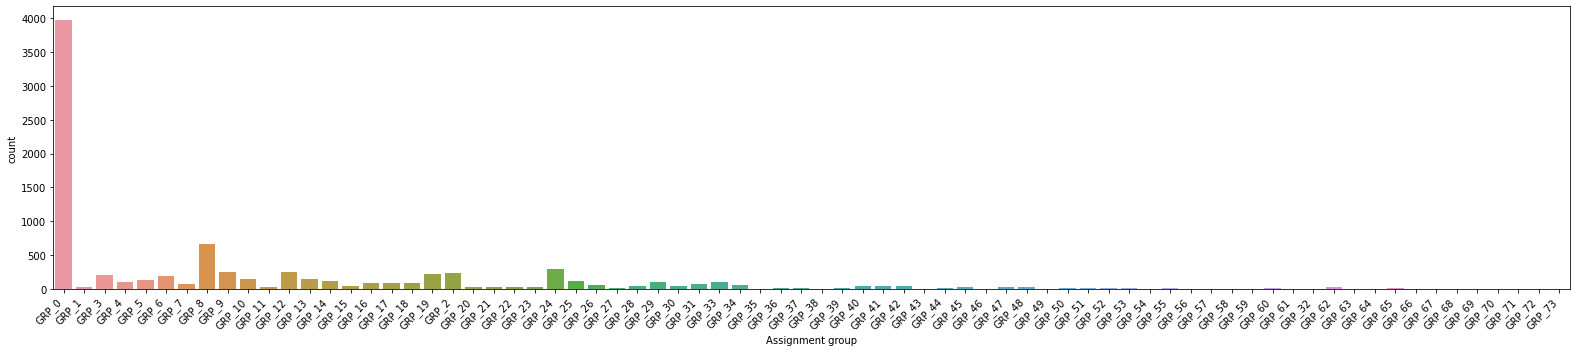

In [33]:
#Lets get the visual representation 
descending_order = clean_df['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
ax=sns.countplot(x='Assignment group', data=clean_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

Length of final description

In [34]:
clean_df['len_final_Description'] = clean_df['combined_sentence'].apply(lambda x: len(x.split(" ")))
clean_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,combined_sentence,Assignment group,len_final_Description
0,verify user detail employee manager name check...,GRP_0,22
1,team meeting skype meeting etc appear outlook ...,GRP_0,13
2,cant hi log vpn best,GRP_0,5
3,unable access hr tool page,GRP_0,5
4,skype error,GRP_0,2


Using Label Encoder for Target Variable

In [35]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(clean_df['Assignment group'])
clean_df['Target'] = le.transform(clean_df['Assignment group'])
clean_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,combined_sentence,Assignment group,len_final_Description,Target
0,verify user detail employee manager name check...,GRP_0,22,0
1,team meeting skype meeting etc appear outlook ...,GRP_0,13,0
2,cant hi log vpn best,GRP_0,5,0
3,unable access hr tool page,GRP_0,5,0
4,skype error,GRP_0,2,0


# WordCloud

Using word cloud to have a overview of most frequent words

In [36]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

stopwords = set(STOPWORDS)
## function to create Word Cloud
def show_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

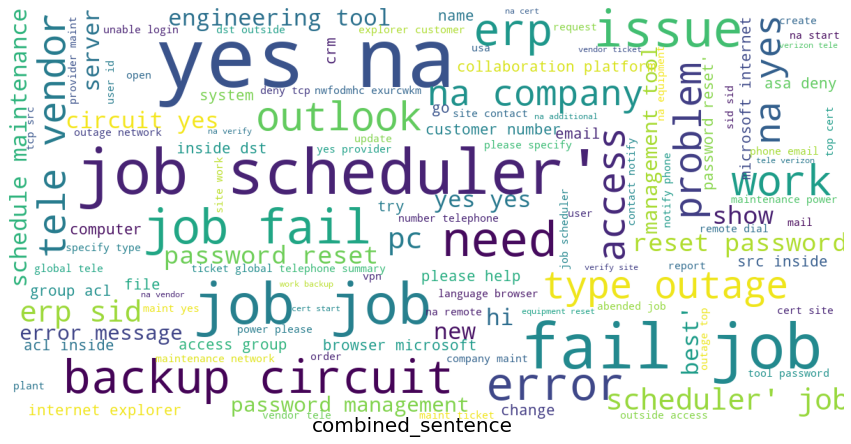

In [37]:
text_Str = clean_df['combined_sentence'].tolist()
show_wordcloud(text_Str,"combined_sentence")

# Model 1: Tf-IFD vector with Multinomial Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    clean_df['combined_sentence'].values, clean_df['Target'].values, 
    test_size=0.2, random_state=0)
print('Training utterances: {}'.format(X_train.shape[0]))
print('Validation utterances: {}'.format(X_test.shape[0]))

Training utterances: 6800
Validation utterances: 1700


In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_train, X_test

(<6800x12709 sparse matrix of type '<class 'numpy.float64'>'
 	with 97377 stored elements in Compressed Sparse Row format>,
 <1700x12709 sparse matrix of type '<class 'numpy.float64'>'
 	with 21515 stored elements in Compressed Sparse Row format>)

In [ ]:
#Feature selection
from sklearn.feature_selection import SelectKBest, chi2

ch2 = SelectKBest(chi2, k=5000)
X_train = ch2.fit_transform(X_train, y_train)
X_test = ch2.transform(X_test)

X_train, X_test

(<6800x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 78928 stored elements in Compressed Sparse Row format>,
 <1700x5000 sparse matrix of type '<class 'numpy.float64'>'
 	with 18395 stored elements in Compressed Sparse Row format>)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [ ]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
print(accuracy_score(y_train, pred_train))
print(accuracy_score(y_test, pred_test))

0.5652941176470588
0.5847058823529412


# Model 2: Glove Embedding with Bernoulli Naive Bayes

In [ ]:
glove_file = "glove.6B.zip"
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [ ]:
EMBEDDING_FILE = './glove.6B.300d.txt'
embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

In [ ]:
from nltk.tokenize import RegexpTokenizer

def description_to_words(comp):
    
    words = RegexpTokenizer('\w+').tokenize(comp)
    words = list(filter(lambda a: a != '', words))
    
    return words

In [ ]:
#Taking average of all word embeddings in a sentence to generate the sentence representation.
data_list = list()
for comp in clean_df['combined_sentence']:
    sentence = np.zeros(300)
    count = 0
    for w in description_to_words(comp):
        try:
            sentence += embeddings[w]
            count += 1.0
        except KeyError:
            continue
    data_list.append(sentence)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data_list), clean_df.Target.values, 
    test_size=2, random_state=0)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(8498, 300)
(8498,)


In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
clf = BernoulliNB()
clf.fit(X_train, y_train)
pred_train = clf.predict(X_train)
print(accuracy_score(y_train, pred_train))

0.39456342668863265


# Model 3: Glove embedding with simple LSTM model

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, LSTM
from keras.models import Model, Sequential

Using TensorFlow backend.


In [ ]:
all_words = list()
for comp in clean_df['combined_sentence']:
    for w in comp.split(" "):
        all_words.append(w)

In [ ]:
vocab = len(all_words)
vocab

167053

In [ ]:
max_features = 18000
maxlen = 300
embedding_size = 300

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(clean_df['combined_sentence']))

In [ ]:
X = tokenizer.texts_to_sequences(clean_df['combined_sentence'])
X = pad_sequences(X, maxlen = maxlen)

from keras.utils import to_categorical
y = to_categorical(clean_df['Target'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 8500
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   

In [ ]:
vocab = tokenizer.word_index
vocab_size = len(vocab)
vocab_size

15094

In [ ]:
from operator import itemgetter
sortedWords = sorted(tokenizer.word_counts.items(), key=itemgetter(1), reverse = True)

In [ ]:
#print first 15 most frequent words
most_freq = {}
for i in range(15):
  most_freq[sortedWords[i][0]] = sortedWords[i][1]
  print(sortedWords[i])

('job', 2578)
('yes', 2027)
('please', 2007)
('na', 1943)
('password', 1673)
('user', 1455)
('erp', 1375)
('company', 1277)
('tool', 1232)
('issue', 1175)
('access', 1066)
('ticket', 1059)
('reset', 1042)
('sid', 984)
('scheduler', 971)


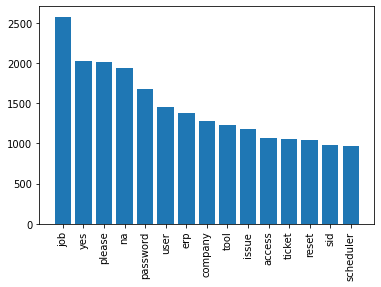

In [ ]:
#Visulaize top 15 words
plt.xticks(rotation=90)
plt.bar(range(len(most_freq)), most_freq.values(), align='center')
plt.xticks(range(len(most_freq)), list(most_freq.keys()))
plt.show()

In [ ]:
all_embs = np.stack(embeddings.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
nb_words = min(max_features, len(vocab))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix

array([[-0.63275659,  0.45930331, -0.3653764 , ..., -0.02303614,
        -0.32111325,  0.23161313],
       [-0.17794999,  0.45583001,  0.45181   , ...,  0.019476  ,
        -0.46919999,  0.30723   ],
       [-0.078738  , -0.2705    ,  0.24003001, ..., -0.13584   ,
        -0.22122   ,  0.42986   ],
       ...,
       [-0.21114001,  0.85600001, -0.36241999, ..., -0.13423   ,
         0.069851  ,  0.028854  ],
       [ 0.91033039,  0.00134184, -0.76113461, ...,  0.20232027,
         0.20973727,  0.50471971],
       [ 0.1474913 , -0.22095887, -0.44395373, ..., -0.04346649,
        -0.69586824,  0.09205031]])

In [ ]:
#Build LSTM Model
model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length = X.shape[1]))
model.add((LSTM(200, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(74, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          5400000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 200)          400800    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                14874     
Total params: 5,815,674
Trainable params: 5,815,674
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 1) 

In [ ]:
batch_size = 100
epochs = 5
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (x_test,y_test))

Train on 6800 samples, validate on 1700 samples
Epoch 1/5
6800/6800 [==============================] - 52s 8ms/step - loss: 1.3456 - accuracy: 0.6684 - val_loss: 1.6895 - val_accuracy: 0.5994
Epoch 2/5
6800/6800 [==============================] - 52s 8ms/step - loss: 1.1929 - accuracy: 0.7018 - val_loss: 1.6513 - val_accuracy: 0.6035
Epoch 3/5
6800/6800 [==============================] - 52s 8ms/step - loss: 1.0528 - accuracy: 0.7360 - val_loss: 1.5903 - val_accuracy: 0.6159
Epoch 4/5
6800/6800 [==============================] - 52s 8ms/step - loss: 0.9258 - accuracy: 0.7644 - val_loss: 1.6162 - val_accuracy: 0.6118
Epoch 5/5
6800/6800 [==============================] - 52s 8ms/step - loss: 0.8172 - accuracy: 0.7934 - val_loss: 1.5709 - val_accuracy: 0.6053


In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

6800/6800 [==============================] - 14s 2ms/step
Accuracy of the model on Training Data is -  81.86764717102051
1700/1700 [==============================] - 3s 2ms/step
Accuracy of the model on Testing Data is -  60.52941083908081


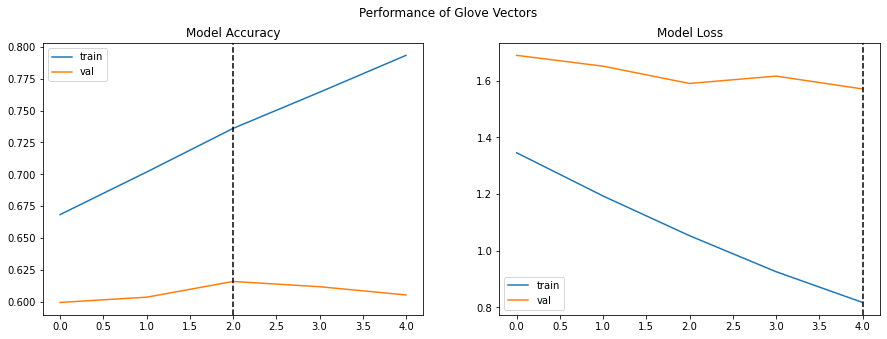

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Glove Vectors")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'val'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'val'])
plt.show()


# Model 4: Golve Embedding with Bidirection LSTM

In [ ]:
#Build Model Bidirectional LSTM
model = Sequential()
model.add(Embedding(nb_words, embedding_size, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(240, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(74, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         4528200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 480)         1038720   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 480)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 74)                35594     
Total params: 5,602,514
Trainable params: 5,602,514
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 1) 

In [ ]:
batch_size = 100
epochs = 10
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (x_test,y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6800 samples, validate on 1700 samples
Epoch 1/10
6800/6800 [==============================] - 105s 16ms/step - loss: 2.1172 - accuracy: 0.5326 - val_loss: 1.7519 - val_accuracy: 0.5812
Epoch 2/10
6800/6800 [==============================] - 103s 15ms/step - loss: 1.4796 - accuracy: 0.6257 - val_loss: 1.4949 - val_accuracy: 0.6059
Epoch 3/10
6800/6800 [==============================] - 104s 15ms/step - loss: 1.1656 - accuracy: 0.6910 - val_loss: 1.3455 - val_accuracy: 0.6506
Epoch 4/10
6800/6800 [==============================] - 103s 15ms/step - loss: 0.9140 - accuracy: 0.7544 - val_loss: 1.3343 - val_accuracy: 0.6335
Epoch 5/10
6800/6800 [==============================] - 104s 15ms/step - loss: 0.7296 - accuracy: 0.7987 - val_loss: 1.3042 - val_accuracy: 0.6588
Epoch 6/10
6800/6800 [==============================] - 104s 15ms/step - loss: 0.5540 - accuracy: 0.8471 - val_loss: 1.3189 - val_accuracy: 0.6471
Epoch 7/10
6800/6800 [==============================] - 104s 15ms/step

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

6800/6800 [==============================] - 29s 4ms/step
Accuracy of the model on Training Data is -  93.73529553413391
1700/1700 [==============================] - 7s 4ms/step
Accuracy of the model on Testing Data is -  64.05882239341736


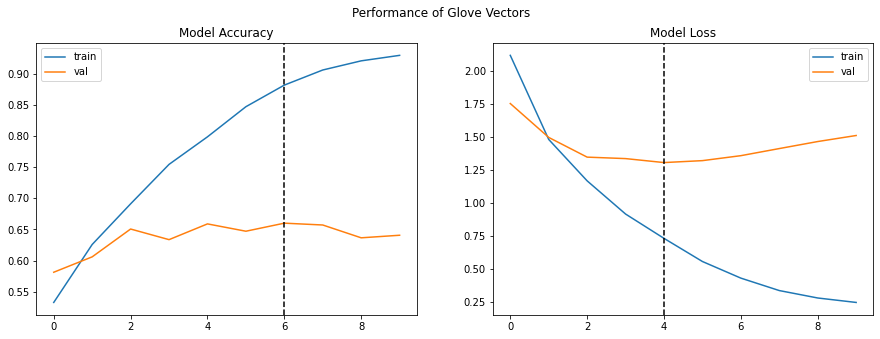

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Glove Vectors")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'val'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'val'])
plt.show()


# Summary

Data having 4 columns named as 'Short description',	'Description'	'Caller'	and
'Assignment group'(Target Col)

Merged 'Short description' and	'Description' with some techinque to get 'Combined Sentence(Feature Col) and drop 'Caller' as it is of no use

Preprocess the feature col to get clean senetence for our model and also preprocess our target column to feed into model.


---
**Model Performance**

Model 1: **Multinomail NB** with TF-IDF

    Score: 58%
Model 2: **Bernoli NB** with Embeddings

    Score: 39%
Model 3: **LSTM**

    Score: 60%
Model 4: **Bidirectional LSTM**

    Score: 64%





# Future Improvemets

There are some other language in the data. So will try google translate api to convert it to EN.

We will also train the glove embedding to get better accuracy.

We will run our model for longer epochs to get better accuracy.

We know that data is skewed towards GRP_0. So we will try 2 different model (Grp0 and other Grps) and combine the result to get better accuracy.

We will combine those groups which has less data to make a misc group to get better accuracy.

We will also try **Transformer model** and check if it gives us better result.


In [38]:
clean_df[['combined_sentence','Assignment group']]

,combined_sentence,Assignment group
0,verify user detail employee manager name check...,GRP_0
1,team meeting skype meeting etc appear outlook ...,GRP_0
2,cant hi log vpn best,GRP_0
3,unable access hr tool page,GRP_0
4,skype error,GRP_0
...,...,...
8495,come good afternoon receive email send zz mail...,GRP_29
8496,telephony software issue,GRP_0
8497,vip window password reset tifpdchb pedxruyf,GRP_0
8498,est funcionando unable access machine utility ...,GRP_62


Training the model after resampling

In [39]:
data_resample = clean_df[['combined_sentence','Assignment group']]
data_resample.head()

,combined_sentence,Assignment group
0,verify user detail employee manager name check...,GRP_0
1,team meeting skype meeting etc appear outlook ...,GRP_0
2,cant hi log vpn best,GRP_0
3,unable access hr tool page,GRP_0
4,skype error,GRP_0


In [40]:
clean_df.groupby('Assignment group')['Assignment group'].count().sort_values(ascending=False)

Assignment group
GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_67       1
GRP_61       1
GRP_73       1
GRP_35       1
GRP_70       1
Name: Assignment group, Length: 74, dtype: int64

In [41]:
from sklearn.utils import resample

In [42]:
data_resample.columns

Index(['combined_sentence', 'Assignment group'], dtype='object')

In [43]:
resampled_DF = data_resample[0:0]
samples = 661 #Apart from GRP_0 we see 661 is highest number of groups hold by GRP_8
overall_groups = data_resample['Assignment group'].unique()
for group in overall_groups:
    resampleGRP = data_resample[data_resample['Assignment group'] == group]
    resampled = resample(resampleGRP, replace=True, n_samples=int(samples), random_state=123)
    resampled_DF = resampled_DF.append(resampled)

In [44]:
resampled_DF.head()

,combined_sentence,Assignment group
7579,require please kindly set mobile link company ...,GRP_0
7323,login issue verify user detail employee manage...,GRP_0
7357,audio summary sound work pc,GRP_0
2790,window password reset request,GRP_0
2327,ticket update inplant,GRP_0


In [45]:
resampled_DF.shape

(48914, 2)

In [46]:
resampled_DF.groupby('Assignment group')['Assignment group'].count().sort_values(ascending=False)

Assignment group
GRP_9     661
GRP_25    661
GRP_27    661
GRP_28    661
GRP_29    661
         ... 
GRP_53    661
GRP_54    661
GRP_55    661
GRP_56    661
GRP_0     661
Name: Assignment group, Length: 74, dtype: int64

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(resampled_DF['Assignment group'])
resampled_DF['Target'] = le.transform(resampled_DF['Assignment group'])
resampled_DF.head()

,combined_sentence,Assignment group,Target
7579,require please kindly set mobile link company ...,GRP_0,0
7323,login issue verify user detail employee manage...,GRP_0,0
7357,audio summary sound work pc,GRP_0,0
2790,window password reset request,GRP_0,0
2327,ticket update inplant,GRP_0,0


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, LSTM
from keras.models import Model, Sequential

Using TensorFlow backend.


In [ ]:
max_features = 12000
maxlen = 300 #Keeping 300 by considering the length of all the sentences
embedding_size = 300

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(resampled_DF['combined_sentence']))

In [ ]:
X = tokenizer.texts_to_sequences(resampled_DF['combined_sentence'])
X = pad_sequences(X, maxlen = maxlen)

from keras.utils import to_categorical
y = to_categorical(resampled_DF['Target'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 48914
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0  

In [ ]:
vocab = tokenizer.word_index
vocab_size = len(vocab)
vocab_size

12114

In [ ]:
project_path = '/content/drive/My Drive/GL/Capstone_Project/'
glove_file = project_path + "glove.6B.zip"

In [ ]:
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [ ]:
EMBEDDING_FILE = './glove.6B.300d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    #print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    #print(embd)
    embeddings[word] = embd

In [ ]:
all_embs = np.stack(embeddings.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
nb_words = min(max_features, len(vocab))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix

array([[ 0.11755915, -0.23672907,  0.16992823, ..., -0.06183447,
        -0.40819068, -0.46137359],
       [-0.049169  , -0.30989999, -0.40156999, ..., -0.47082001,
         0.31920001,  0.0268    ],
       [-0.44189   ,  0.24247999, -0.22996999, ..., -0.77638   ,
        -0.054478  , -0.13019   ],
       ...,
       [-0.29341431, -0.09289527,  0.17543371, ...,  0.57444682,
         0.55768691, -0.03085125],
       [ 0.29558   , -0.31101999,  0.25793999, ...,  0.41780001,
         0.12773   , -0.030918  ],
       [-0.26455698, -0.54022905, -0.36077737, ..., -0.06670133,
         0.32301526, -0.74885652]])

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(240, return_sequences = True)))
model.add(GlobalMaxPool1D())
#model.add(Dense(120, activation="relu"))
#model.add(Dropout(0.5))
model.add(Dense(74, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         3600000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 480)         1038720   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 480)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 74)                35594     
Total params: 4,674,314
Trainable params: 4,674,314
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 1) 

In [ ]:
batch_size = 300
epochs = 5
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (x_test,y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 39131 samples, validate on 9783 samples
Epoch 1/5
39131/39131 [==============================] - 142s 4ms/step - loss: 1.7154 - accuracy: 0.6558 - val_loss: 0.6111 - val_accuracy: 0.8499
Epoch 2/5
39131/39131 [==============================] - 141s 4ms/step - loss: 0.4021 - accuracy: 0.8974 - val_loss: 0.3174 - val_accuracy: 0.9114
Epoch 3/5
39131/39131 [==============================] - 144s 4ms/step - loss: 0.2514 - accuracy: 0.9312 - val_loss: 0.2441 - val_accuracy: 0.9278
Epoch 4/5
39131/39131 [==============================] - 142s 4ms/step - loss: 0.1865 - accuracy: 0.9430 - val_loss: 0.2038 - val_accuracy: 0.9368
Epoch 5/5
39131/39131 [==============================] - 145s 4ms/step - loss: 0.1561 - accuracy: 0.9485 - val_loss: 0.1845 - val_accuracy: 0.9398


In [ ]:
print("Accuracy of the resampled model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the resampled model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

39131/39131 [==============================] - 107s 3ms/step
Accuracy of the resampled model on Training Data is -  95.28762102127075
9783/9783 [==============================] - 27s 3ms/step
Accuracy of the resampled model on Testing Data is -  93.97935271263123


Doing text augmentation

In [ ]:
data_group = clean_df[['combined_sentence','Assignment group']]
data_group.head()

,combined_sentence,Assignment group
0,verify user detail employee manager name check...,GRP_0
1,team meeting skype meeting etc appear outlook ...,GRP_0
2,cant hi log vpn best,GRP_0
3,unable access hr tool page,GRP_0
4,skype error,GRP_0


In [ ]:
#import os
#os.environ["MODEL_DIR"] = '../model'

In [ ]:
pip install nlpaug numpy matplotlib python-dotenv

In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [ ]:
text = 'The quick brown fox jumps over the lazy dog '
print(text)

The quick brown fox jumps over the lazy dog 


In [ ]:
#pip install transformers

     |████████████████████████████████| 778kB 4.3MB/s 
     |████████████████████████████████| 1.1MB 11.6MB/s 
     |████████████████████████████████| 890kB 24.3MB/s 
     |████████████████████████████████| 3.0MB 31.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=5a7a228af4e7423b31e9866c6b689369aecf02a04435b785a5934541a84cb7dd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#!pip install pytorch_pretrained_bert pytorch-nlp

     |████████████████████████████████| 133kB 5.2MB/s 
     |████████████████████████████████| 92kB 7.7MB/s 


In [ ]:
#from pytorch_pretrained_bert import BertTokenizer

In [ ]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
#from transformers import BertTokenizer
#slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [ ]:
#slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#save_path = "bert_base_uncased/"
#if not os.path.exists(save_path):
#    os.makedirs(save_path)
#slow_tokenizer.save_pretrained(save_path)

In [ ]:
aug = naw.ContextualWordEmbsAug(
    model_path= 'bert-base-uncased', action="insert")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

NameError: ignored

In [ ]:
aug = naw.SpellingAug(os.environ["MODEL_DIR"] + 'spelling_en.txt')
augmented_texts = aug.augment(text, n=3)
print("Original:")
print(text)
print("Augmented Texts:")
print(augmented_texts)

Original:
The quick brown fox jumps over the lazy dog .
Augmented Texts:
['Ihe quick brown fox jumps other tge lazy dog .', 'Te quick brown fox jumps over d laizy dog .', 'THe quick brown fox jumps ower the lazy doga .']


In [ ]:
aug = naw.TfIdfAug(
    model_path=os.environ.get("MODEL_DIR"),
    action="insert")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

FileNotFoundError: ignored

In [ ]:
os.environ.get("MODEL_DIR")

'../model'

In [ ]:
aug = naw.SynonymAug(aug_src='wordnet')
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The quick brown fox jumps over the lazy dog 
Augmented Text:
The quick robert brown george fox jumps over the lazy dog


In [ ]:
aug = naw.RandomWordAug(action="swap")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The quick brown fox jumps over the lazy dog 
Augmented Text:
The quick brown fox over jumps the dog lazy


In [ ]:
aug = naw.RandomWordAug()
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The quick brown fox jumps over the lazy dog 
Augmented Text:
The quick brown jumps over the dog
